In [80]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import biovec

# Read Data

In [81]:
data = np.load("../../output/ppi_as_vec.npy")
data

array([[ 0.97499549,  0.19626933,  0.45749313, ...,  0.07362792,
         0.53396142,  0.        ],
       [ 1.05078506,  0.29231763,  0.19424087, ...,  0.12072353,
         0.38534316,  1.        ],
       [ 0.64099419,  0.01247711, -0.01030196, ...,  0.48067993,
        -0.27393717,  1.        ],
       ...,
       [ 0.9370383 ,  0.03682944,  0.31517491, ...,  0.40015069,
         0.51669538,  1.        ],
       [ 1.13437223, -0.20479627,  0.32728988, ...,  0.16014186,
         0.45244536,  0.        ],
       [ 1.30530214, -0.08957833,  0.31159812, ...,  0.19718666,
         0.54793459,  1.        ]])

In [82]:
X = data[:,:-1]
y = data[:,-1:]

In [83]:
N = int(len(y)/5) # for debugging only on part of the dataset
test_size = int(N/10)
data_ixs = np.random.permutation(np.arange(N))

X_test = X[data_ixs[:test_size], :]
y_test = y[data_ixs[:test_size], :]

X_train = X[data_ixs[test_size:], :]
y_train = y[data_ixs[test_size:], :]

# Create Model

In [88]:
def batch_data(num_data, batch_size):
    """ Yield batches with indices until epoch is over.
    
    Parameters
    ----------
    num_data: int
        The number of samples in the dataset.
    batch_size: int
        The batch size used using training.

    Returns
    -------
    batch_ixs: np.array of ints with shape [batch_size,]
        Yields arrays of indices of size of the batch size until the epoch is over.
    """
    
    data_ixs = np.random.permutation(np.arange(num_data))
    ix = 0
    while ix + batch_size < num_data:
        batch_ixs = data_ixs[ix:ix+batch_size]
        ix += batch_size
        yield batch_ixs
    

class FeedForwardNet:
    """
    Simple feed forward neural network class
    """
    
    def __init__(self, hidden_sizes, layer_types, name, l2_reg=0.0):
        """ FeedForwardNet constructor.
        
        Parameters
        ----------
        hidden_sizes: list of ints
            The sizes of the hidden layers of the network.
        name: str
            The name of the network (used for a VariableScope)
        l2_reg: float
            The strength of L2 regularization (0 means no regularization)
        """
        
        self.hidden_sizes = hidden_sizes
        self.layer_types = layer_types
        self.name = name
        self.dropout = tf.placeholder_with_default(0.0, shape=(), name="dropout")
        self.l2_reg = l2_reg
        self.weights =[]
        self.biases =[]
    
    def build(self, data_dim, num_classes):
        """ Construct the model.
        
        Parameters
        ----------
        data_dim: int
            The dimensions of the data samples.

        Returns
        -------
        None

        """
        self.X = tf.placeholder(shape=[None, data_dim], dtype=tf.float32, name="data") #[NxD]
        self.Y = tf.placeholder(shape=[None, num_classes], dtype=tf.float32, name="labels") #[Nx1]
    
        with tf.variable_scope(self.name):
        
            hidden = self.X

            for ix, hidden_size in enumerate(self.hidden_sizes):
                W = tf.get_variable(f"W_{ix}", shape=[int(hidden.shape[1]), hidden_size])
                b = tf.get_variable(f"b_{ix}", shape=[hidden_size,])
                self.weights.append(W)
                self.biases.append(b)
                hidden = self.layer_types[ix](hidden @ W + b)
                hidden = tf.nn.dropout(hidden, keep_prob=1-self.dropout) 
                    
            W_out = tf.get_variable("W_out", shape=[int(hidden.shape[1]), num_classes])
            b_out = tf.get_variable("b_out", shape=[num_classes,])
            self.weights.append(W_out)
            self.biases.append(b_out)
            
            self.logits = hidden @ W_out + b_out
            self.l2_norm = tf.add_n([tf.norm(w) for w in self.weights])
            self.cross_entropy_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=self.logits, 
                                                                              labels=self.Y), name="cross_entropy_loss")
            self.accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(self.logits, 1), 
                                                            tf.argmax(self.Y,1)),
                                                   tf.float32), name="accuracy")
            
            self.loss = self.cross_entropy_loss + self.l2_reg * self.l2_norm
            
            self.optimizer = tf.train.AdamOptimizer()
            self.opt_op = self.optimizer.minimize(self.loss, var_list=[*self.weights, *self.biases])
            
        
    def train(self, train_data, train_labels, val_data, val_labels, epochs=20, dropout=0.0, batch_size=512):
        """ Train the feed forward neural network.
        
        Parameters
        ----------
        train_data: np.array, dtype float32, shape [N, D]
            The training data. N corresponds to the number of training samples, D to the dimensionality of the data samples/
        train_labels: np.array, shape [N, K]
            The labels of the training data, where K is the number of classes.
        val_data: np.array, dtype float32, shape [N_val, D]
            The validation data. N_val corresponds to the number of validation samples, D to the dimensionality of the data samples/
        val_labels: np.array, shape [N_val, K]
            The labels of the training data, where K is the number of classes.
        epochs: int
            The number of epochs to train for.
        dropout: float
            The dropout rate used during training. 0 corresponds to no dropout.
        batch_size: int
            The batch size used for training.

        Returns
        -------
        None

        """
        train_losses = []
        train_accs = []
        val_losses = []
        val_accs = []
        
        self.session = tf.Session()
        session = self.session
        
        with session.as_default():
            session.run(tf.global_variables_initializer())
            
            tr_loss, tr_acc = session.run([self.loss, self.accuracy], feed_dict={self.X: train_data,
                                                                                self.Y: train_labels})
            val_loss, val_acc = session.run([self.loss, self.accuracy], feed_dict={self.X: val_data,
                                                                                self.Y: val_labels})
            train_losses.append(tr_loss)
            train_accs.append(tr_acc)
            
            val_losses.append(val_loss)
            val_accs.append(val_acc)
                        
            for epoch in range(epochs):
                if (epoch + 1) % 25 == 0:
                    print(f"Epoch {epoch+1}/{epochs}")
                for batch_ixs in batch_data(len(train_data), batch_size):
                    _ = session.run(self.opt_op, feed_dict={self.X: train_data[batch_ixs],
                                                            self.Y: train_labels[batch_ixs],
                                                            self.dropout: dropout})
                    tf.get_variable_scope().reuse_variables()
                    
                tr_loss, tr_acc= session.run([self.loss, self.accuracy], feed_dict={self.X: train_data,
                                                                                    self.Y: train_labels})
                val_loss, val_acc= session.run([self.loss, self.accuracy], feed_dict={self.X: val_data,
                                                                                    self.Y: val_labels})
                train_losses.append(tr_loss)
                train_accs.append(tr_acc)

                val_losses.append(val_loss)
                val_accs.append(val_acc)    
                tf.get_variable_scope().reuse_variables()
    
        self.hist={'train_loss': np.array(train_losses),
           'train_accuracy': np.array(train_accs),
           'val_loss': np.array(val_losses),
           'val_accuracy': np.array(val_accs)}

In [89]:
layer_types = [tf.nn.relu, tf.nn.relu, tf.nn.relu]
tf.get_variable_scope().reuse_variables()
hidden_sizes = [5]
epochs = 100
batch_size = 100

In [90]:
NN_no_regularization = FeedForwardNet(hidden_sizes, layer_types, "no_regularization")
NN_no_regularization.build(X_train.shape[1], num_classes=y_train.shape[1])

In [91]:
NN_no_regularization.train(X_train, y_train, X_test, y_test, epochs,
                          batch_size=batch_size)

Epoch 25/100
Epoch 50/100
Epoch 75/100
Epoch 100/100


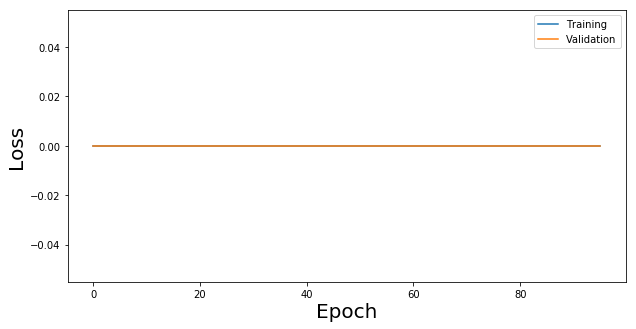

In [92]:
plt.figure(figsize=(10,5))
plt.plot(NN_no_regularization.hist['train_loss'][5::], label="Training")
plt.plot(NN_no_regularization.hist['val_loss'][5::], label="Validation")

plt.xlabel("Epoch", fontsize=20)
plt.ylabel("Loss", fontsize=20)
plt.legend()
plt.show()

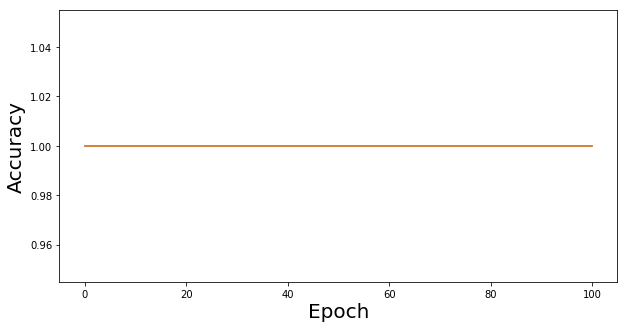

In [70]:
plt.figure(figsize=(10,5))

plt.plot(NN_no_regularization.hist['train_accuracy'])
plt.plot(NN_no_regularization.hist['val_accuracy'])

plt.xlabel("Epoch", fontsize=20)
plt.ylabel("Accuracy", fontsize=20)

plt.show()